In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
print(tf.__version__)

2.3.1


> **Ignoring the wildlife.h5 file as not needed for this exercise.**

# **Investigate the dataset**
* How many of each class of animal do we have 

In [2]:
PATH = '../input/oregon-wildlife/oregon_wildlife/oregon_wildlife/'
animal_list = os.listdir(PATH)

for animal in animal_list:
    number = len(os.listdir(PATH+animal))
    print('There are ', number, animal, 'images')
print('There are ', len(animal_list), 'total categories')

There are  577 mountain_beaver images
There are  728 raccoon images
There are  728 virginia_opossum images
There are  696 bobcat images
There are  736 coyote images
There are  660 elk images
There are  656 raven images
There are  588 ringtail images
There are  680 cougar images
There are  668 gray_fox images
There are  735 columbian_black-tailed_deer images
There are  759 red_fox images
There are  730 gray_wolf images
There are  698 seals images
There are  701 nutria images
There are  748 bald_eagle images
There are  764 deer images
There are  718 black_bear images
There are  717 canada_lynx images
There are  726 sea_lions images
There are  20 total categories


# **Now visualize an image from each category**

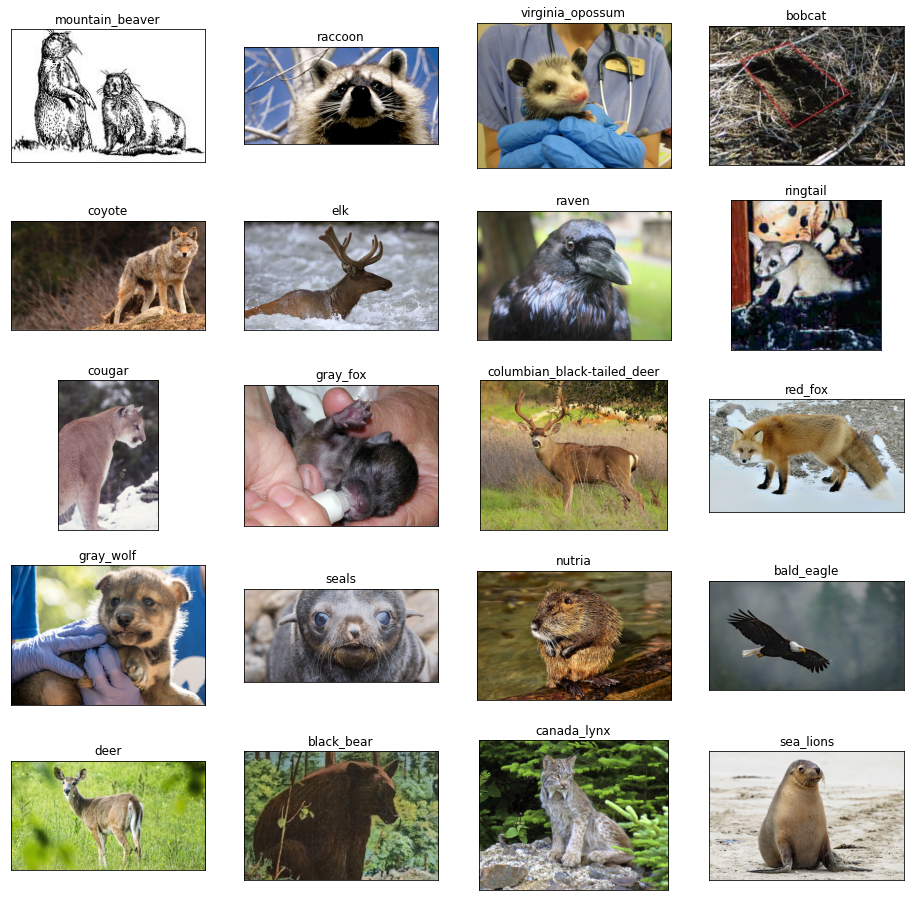

In [3]:
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 5
i=0
for animal in animal_list:
    i+=1
    file = os.listdir(PATH+animal)[0]
    img = Image.open(PATH+animal+'/'+file)
    fig.add_subplot(rows, columns, i, xticks=[], yticks=[])
    plt.title(animal)
    plt.imshow(img)

# Load and split the data in to test, train, validation sets
Use Keras.preprocessing.image_dataset_from_directory to generate train, test and validation sets.
The training and validation steps are from: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb

In [4]:
#Set the batch size, and image height and width
batch_size = 32
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)

In [5]:
#Generate the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="training",
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14013 files belonging to 20 classes.
Using 11211 files for training.


In [6]:
#Generate the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14013 files belonging to 20 classes.
Using 2802 files for validation.


Since there was not test set create one from the validation dataset.  In this case we are finding the cardinality `tf.data.experimental.cardinality` of the validation dataset (val_ds).  Then create a test dataset from that by using the take `tf.data.Dataset.take()` method and 20% (val_batches // 5) where the '//' is a floor division.  Then takes the unused elements of val_ds to remain in the val_ds.

In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_sd = val_ds.skip(val_batches // 5)

**Verification that the class names are valid and there are the correct number.**

In [8]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('Class names are: ', class_names, '/n The number of classes is: ', num_classes)

Class names are:  ['bald_eagle', 'black_bear', 'bobcat', 'canada_lynx', 'columbian_black-tailed_deer', 'cougar', 'coyote', 'deer', 'elk', 'gray_fox', 'gray_wolf', 'mountain_beaver', 'nutria', 'raccoon', 'raven', 'red_fox', 'ringtail', 'sea_lions', 'seals', 'virginia_opossum'] /n The number of classes is:  20


1. In the next few steps we will load the `tf.keras.applications.MobileNetV2` base model. This model needs to be preprocessed with values between [-1,1] so we will process the inputs to it with `tf.keras.applications.mobilenet_v2.preprocess_input`.

In [9]:
from tensorflow.keras import layers

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Setup buffering and prefetching of the training and validation datasets

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  #This sets up the runtime to dynamically tune the buffersize 

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

* **Here I'm loading the MobileNetV2 model from Keras.  I'm not including the top layer, so I can create a cutom classification layer.**

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each 160x160x3 image into a n x n x p block of features in order to always be able to get the correct size for the new feature extration layer we'll measure the shape of a batch of data from the train_dataset.  The output will be a tensor of shape (batch_size, n, n, p).

In [12]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


# Feature Extraction
In this section we freeze the base model layers so the pre-learned weights and biases aren't updated during training and then add the new classifier on top and train.

In [13]:
base_model.trainable = False

The base model layers need to be frozen, this way the weights in the layers, except for the top layer won't be updated during training.  The top layer is not included in order to add a custom classifier layer with the 20 classes we're training on.  See this [TensorFlow Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning#feature_extraction).  As we'll see MobilNet contains batch normalization layers, and special care should be taken as described here: [BatchNorm Description](https://www.tensorflow.org/tutorials/images/transfer_learning#important_note_about_batchnormalization_layers)

In [14]:
base_model.summary()  #Look at the model architecture

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

Help and inputs at this step are from [Adding a Classification Head](https://www.tensorflow.org/tutorials/images/transfer_learning#add_a_classification_head)  In order to use the output to create a classification layer the output of the base model is,  n,n,p.  Need to convert this to a single 1280 element vector so this is done by using a average pooling layer.

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='prediction')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 20)


In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.models.Model(inputs, outputs)

# Compile the Model
Compile the model before training.  There are two classes, uses sparse_catgegorical_crossentropy 

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
prediction (Dense)           (None, 20)               

# Train the model
Setup initial training parameters and evaluation criterial

In [20]:
epochs = 10

In [21]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10
351/351 [==============================] - 288s 820ms/step - loss: 2.8024 - accuracy: 0.4012 - val_loss: 2.5764 - val_accuracy: 0.6542
Epoch 2/10
351/351 [==============================] - 12s 35ms/step - loss: 2.4804 - accuracy: 0.7135 - val_loss: 2.4323 - val_accuracy: 0.7355
Epoch 3/10
351/351 [==============================] - 12s 35ms/step - loss: 2.3897 - accuracy: 0.7700 - val_loss: 2.3794 - val_accuracy: 0.7698
Epoch 4/10
351/351 [==============================] - 13s 36ms/step - loss: 2.3513 - accuracy: 0.7911 - val_loss: 2.3528 - val_accuracy: 0.7862
Epoch 5/10
351/351 [==============================] - 12s 35ms/step - loss: 2.3309 - accuracy: 0.8038 - val_loss: 2.3357 - val_accuracy: 0.7941
Epoch 6/10
351/351 [==============================] - 12s 35ms/step - loss: 2.3153 - accuracy: 0.8111 - val_loss: 2.3239 - val_accuracy: 0.8009
Epoch 7/10
351/351 [==============================] - 12s 35ms/step - loss: 2.3039 - accuracy: 0.8180 - val_loss: 2.3141 - val_accurac

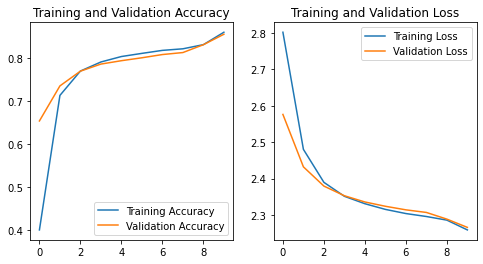

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Baseline Model Performance
The baseline model, which contained no augmentation or fine tuning had a validation dataset accuracy of 85%.

In [23]:
#This will evaluate the baseline model against the test dataset.
test_loss, test_accuracy = model.evaluate(test_ds)
print('Test dataset loss: ', test_loss, 'Test dataset accuracy: ', test_accuracy)

17/17 [==============================] - 6s 349ms/step - loss: 2.2477 - accuracy: 0.8732
Test dataset loss:  2.2477364540100098 Test dataset accuracy:  0.873161792755127


# Visualize the feature maps for an example image

In [24]:
from keras.models import Model
#This will create a model that outputs the feature maps generated the output of block 1
feature_model = Model(inputs=base_model.inputs, outputs=base_model.layers[17].output)
feature_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
bn_Conv1 (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
Conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
expanded_conv_depthwise (Dep (None, 112, 112, 32)      288       
_________________________________________________________________
expanded_conv_depthwise_BN ( (None, 112, 112, 32)     

In [25]:
#Here a single image is loaded in order to generate the feature maps
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
animal = 'elk'
file = os.listdir(PATH+animal)[3]
#Load a sample image and size resize to the shape expected by the model (img_height, img_width)
img = load_img(PATH+animal+'/'+file, target_size=(img_height, img_width))
#Convert to an array
img = img_to_array(img)
#Expand dimenstion so that it represents a single 'sample
img = expand_dims(img, axis=0)
#Prepare the imgage for Mobilnet
img = preprocess_input(img)

In [26]:
#This will process the single image loaded above throught the base model
feature_maps = feature_model.predict(img)

It is interesting to note the fine details identified in the first block of MobileNet.  Upon changing to be the last output block the feature maps are very generalized.

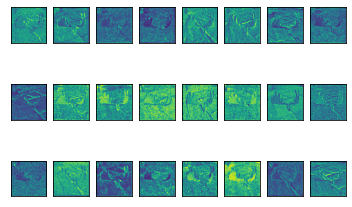

In [27]:
#plot 24 maps on the output of the first block in MobileNet
rows = 3
columns = 8
ix = 1
for _ in range(rows):
    for _ in range(columns):
        ax = plt.subplot(rows, columns, ix)
        
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0,:,:,ix-1], cmap='viridis')
        ix += 1
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

# Fine Tuning
This next section Block 16 of the base model will be set as trainable.  The model will them be trained to see if improvements can be made on the model performance.

In [28]:
base_model.trainable = True

In [29]:
num_layers = len(base_model.layers)
print('Number of layers in the base model: ', num_layers)

fine_tune_at = num_layers-16 #this will unfreeze the block15 and block16

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  155


# Re-compile the model
Since I'm changing the trainable parameter of some layers of the model it needs to be re-compiled before retraining in order that the changes take effect. 

In [30]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
prediction (Dense)           (None, 20)               

In [32]:
fine_tune_epochs = 20
total_epochs = epochs + fine_tune_epochs
history_fine = model.fit(train_ds, 
                    validation_data=val_ds,
                    initial_epoch = history.epoch[-1],
                    epochs=total_epochs)

Epoch 10/30
351/351 [==============================] - 14s 41ms/step - loss: 2.2912 - accuracy: 0.8317 - val_loss: 2.2538 - val_accuracy: 0.8569
Epoch 11/30
351/351 [==============================] - 13s 38ms/step - loss: 2.2510 - accuracy: 0.8659 - val_loss: 2.2391 - val_accuracy: 0.8683
Epoch 12/30
351/351 [==============================] - 13s 38ms/step - loss: 2.2303 - accuracy: 0.8842 - val_loss: 2.2277 - val_accuracy: 0.8772
Epoch 13/30
351/351 [==============================] - 13s 38ms/step - loss: 2.2138 - accuracy: 0.8952 - val_loss: 2.2196 - val_accuracy: 0.8847
Epoch 14/30
351/351 [==============================] - 13s 38ms/step - loss: 2.2018 - accuracy: 0.9057 - val_loss: 2.2114 - val_accuracy: 0.8911
Epoch 15/30
351/351 [==============================] - 13s 38ms/step - loss: 2.1921 - accuracy: 0.9140 - val_loss: 2.2042 - val_accuracy: 0.8983
Epoch 16/30
351/351 [==============================] - 13s 38ms/step - loss: 2.1822 - accuracy: 0.9220 - val_loss: 2.1990 - val_ac

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

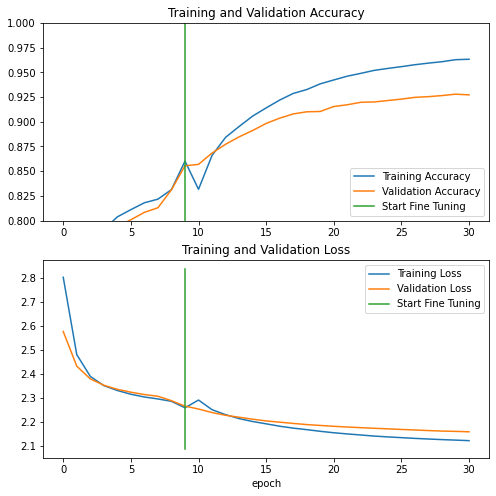

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_ds)
print('Test dataset loss: ', loss, 'Test dataset accuracy: ', accuracy)

17/17 [==============================] - 6s 370ms/step - loss: 2.1612 - accuracy: 0.9228
Test dataset loss:  2.1612000465393066 Test dataset accuracy:  0.9227941036224365


Thanks to the following website for hints on converting the tensorflow confusion matrix to the dataframe and plotting: [TensorFlow Keras Confusion Matrix in TensorBoard](https://androidkt.com/keras-confusion-matrix-in-tensorboard/)

In [36]:
predictions = np.array([])
labels = np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=1)])
    labels = np.concatenate([labels, y.numpy()])
    #print('predict= ', predictions, 'label= ', labels)
con_mat = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
con_mat_norm = np.around(con_mat.astype('float')/con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index=class_names, columns=class_names)

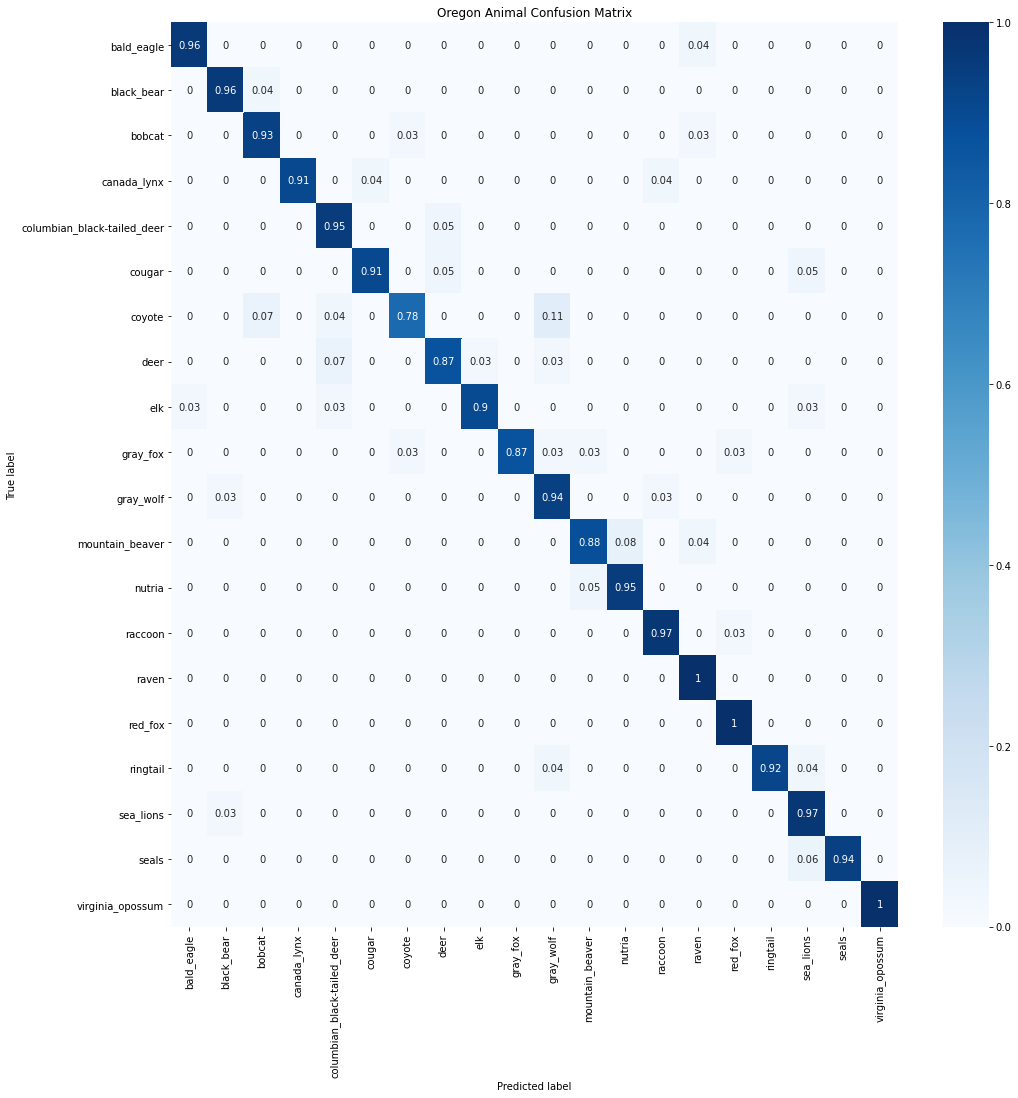

In [37]:
import seaborn as sns
figure = plt.figure(figsize=(15,15))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Oregon Animal Confusion Matrix')
plt.show()

Save the model and the weights that could be used later.

In [38]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")